In [0]:
# Import the machine learning libraries.
import numpy as np
import pylab as pl
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn import metrics

In [0]:
# Load the Human Activity Recognition Using Smartphones dataset.
# The dataset can be downloaded here: https://www.kaggle.com/uciml/human-activity-recognition-with-smartphones.
train = shuffle(pd.read_csv("./drive/My Drive/ML_Code/Human Activity Recognition/train.csv"))
test = shuffle(pd.read_csv("./drive/My Drive/ML_Code/Human Activity Recognition/test.csv"))

In [8]:
print(train.shape, test.shape)

(7352, 563) (2947, 563)


In [9]:
train.head(10)

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",...,fBodyBodyAccJerkMag-entropy(),fBodyBodyAccJerkMag-maxInds,fBodyBodyAccJerkMag-meanFreq(),fBodyBodyAccJerkMag-skewness(),fBodyBodyAccJerkMag-kurtosis(),fBodyBodyGyroMag-mean(),fBodyBodyGyroMag-std(),fBodyBodyGyroMag-mad(),fBodyBodyGyroMag-max(),fBodyBodyGyroMag-min(),fBodyBodyGyroMag-sma(),fBodyBodyGyroMag-energy(),fBodyBodyGyroMag-iqr(),fBodyBodyGyroMag-entropy(),fBodyBodyGyroMag-maxInds,fBodyBodyGyroMag-meanFreq(),fBodyBodyGyroMag-skewness(),fBodyBodyGyroMag-kurtosis(),fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-std(),fBodyBodyGyroJerkMag-mad(),fBodyBodyGyroJerkMag-max(),fBodyBodyGyroJerkMag-min(),fBodyBodyGyroJerkMag-sma(),fBodyBodyGyroJerkMag-energy(),fBodyBodyGyroJerkMag-iqr(),fBodyBodyGyroJerkMag-entropy(),fBodyBodyGyroJerkMag-maxInds,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
6541,0.268731,-0.017147,-0.105590,-0.959594,-0.964239,-0.968673,-0.960276,-0.962235,-0.966444,-0.908847,-0.553773,-0.800046,0.821578,0.683971,0.828345,-0.959341,-0.998999,-0.999620,-0.999115,-0.963826,-0.966864,-0.966180,-0.157527,-0.445538,-0.342894,-0.118661,-0.104695,0.214005,-0.099532,0.196901,-0.217960,0.148381,0.084623,0.111232,-0.053826,-0.029857,0.020527,0.870084,-0.809147,-0.738467,...,-1.000000,-0.936508,0.332887,-0.549982,-0.843379,-0.983837,-0.974425,-0.980045,-0.969388,-0.998107,-0.983837,-0.999617,-0.984829,-0.708857,-1.000000,-0.170740,0.348917,0.079261,-0.991575,-0.991254,-0.990317,-0.993313,-0.995934,-0.991575,-0.999937,-0.990949,-0.871306,-0.968254,-0.091749,-0.401812,-0.791048,-0.214180,-0.652953,0.308889,-0.318881,0.549083,-0.288414,-0.725609,28,LAYING
4016,0.274576,-0.016880,-0.109178,-0.997689,-0.994204,-0.989385,-0.998033,-0.995085,-0.989640,-0.942263,-0.570854,-0.812750,0.848122,0.691863,0.840838,-0.996749,-0.999986,-0.999971,-0.999803,-0.997721,-0.996893,-0.990348,-0.786553,-0.741034,-0.569974,0.344401,-0.123016,0.073616,0.124101,0.514511,-0.223839,0.221398,0.160253,0.370684,-0.129291,0.331795,-0.527058,-0.120431,-0.019621,-0.096779,...,-1.000000,-0.904762,0.175358,-0.421497,-0.755863,-0.992812,-0.995798,-0.995427,-0.995195,-0.992101,-0.992812,-0.999959,-0.993742,-0.924075,-0.692308,0.644407,-0.541015,-0.761746,-0.992047,-0.994011,-0.993073,-0.995533,-0.994118,-0.992047,-0.999952,-0.992925,-0.955696,-0.904762,0.388822,-0.556585,-0.865715,0.559611,0.440299,0.231784,-0.041599,-0.738972,0.116167,0.206063,21,SITTING
495,0.359307,-0.037891,-0.140534,-0.385950,-0.134414,-0.454062,-0.454553,-0.135716,-0.413261,-0.162257,-0.265674,-0.380324,0.235819,0.084020,0.651631,-0.292334,-0.808789,-0.853839,-0.861285,-0.541201,-0.304438,-0.449318,0.588705,0.281680,-0.052936,-0.279311,0.097170,0.008429,0.167148,-0.508011,0.518885,-0.278706,0.156799,-0.496314,0.411552,-0.341371,0.100683,-0.577367,-0.162362,0.242820,...,0.058233,-0.936508,0.050112,-0.273121,-0.674241,-0.621581,-0.542251,-0.545850,-0.579343,-0.901246,-0.621581,-0.885260,-0.567

In [60]:
train.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",...,fBodyBodyAccJerkMag-iqr(),fBodyBodyAccJerkMag-entropy(),fBodyBodyAccJerkMag-maxInds,fBodyBodyAccJerkMag-meanFreq(),fBodyBodyAccJerkMag-skewness(),fBodyBodyAccJerkMag-kurtosis(),fBodyBodyGyroMag-mean(),fBodyBodyGyroMag-std(),fBodyBodyGyroMag-mad(),fBodyBodyGyroMag-max(),fBodyBodyGyroMag-min(),fBodyBodyGyroMag-sma(),fBodyBodyGyroMag-energy(),fBodyBodyGyroMag-iqr(),fBodyBodyGyroMag-entropy(),fBodyBodyGyroMag-maxInds,fBodyBodyGyroMag-meanFreq(),fBodyBodyGyroMag-skewness(),fBodyBodyGyroMag-kurtosis(),fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-std(),fBodyBodyGyroJerkMag-mad(),fBodyBodyGyroJerkMag-max(),fBodyBodyGyroJerkMag-min(),fBodyBodyGyroJerkMag-sma(),fBodyBodyGyroJerkMag-energy(),fBodyBodyGyroJerkMag-iqr(),fBodyBodyGyroJerkMag-entropy(),fBodyBodyGyroJerkMag-maxInds,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject
count,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,...,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000
mean,0.274488,-0.017695,-0.109141,-0.605438,-0.510938,-0.604754,-0.630512,-0.526907,-0.606150,-0.468604,-0.306043,-0.557121,0.523551,0.387386,0.594374,-0.547569,-0.820041,-0.901874,-0.845784,-0.684345,-0.643770,-0.631069,-0.102993,-0.137937,-0.163946,-0.116599,0.102762,-0.037786,0.130477,-0.026229,0.026322,0.159966,-0.019575,0.009420,0.033291,0.036587,-0.078640,-0.125131,-0.193802,0.105005,...,-0.678618,-0.347657,-0.877995,0.178195,-0.312968,-0.615441,-0.693210,-0.692876,-0.674830,-0.726645,-0.885103,-0.693210,-0.874292,-0.719795,-0.087878,-0.889442,-0.046516,-0.253649,-0.565425,-0.779376,-0.792391,-0.772836,-0.811409,-0.871927,-0.779376,-0.935785,-0.771497,-0.284627,-0.898859,0.125293,-0.307009,-0.625294,0.008684,0.002186,0.008726,-0.005981,-0.489547,0.058593,-0.056515,17.413085
std,0.070261,0.040811,0.056635,0.448734,0.502645,0.418687,0.424073,0.485942,0.414122,0.544547,0.282243,0.293867,0.363594,0.343611,0.297818,0.471808,0.259607,0.126333,0.221983,0.371608,0.371581,0.386569,0.468959,0.437268,0.371363,0.306507,0.246593,0.243635,0.230067,0.257383,0.215001,0.208837,0.221432,0.

In [7]:
# Try to find the missing values.
print("Missing values in the training set:", train.isnull().values.any())
print("Missing values in the test set:", test.isnull().values.any())

Missing values in the training set: False
Missing values in the test set: False


In [13]:
# Count up frequency distribution of classes.
train_outcome = pd.crosstab(index=train["Activity"], columns="count")
train_outcome

col_0,count
Activity,
LAYING,1407
SITTING,1286
STANDING,1374
WALKING,1226
WALKING_DOWNSTAIRS,986
WALKING_UPSTAIRS,1073


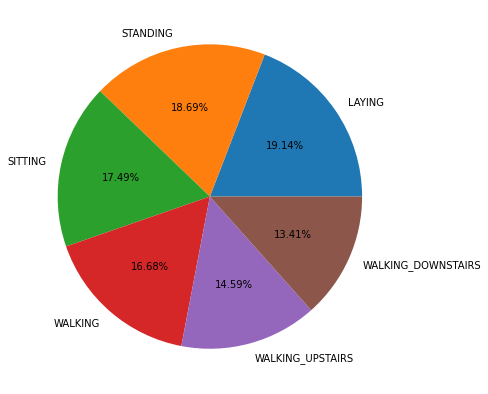

In [43]:
# Visualize frequency distribution of classes.
temp = train["Activity"].value_counts()
df = pd.DataFrame({'labels': temp.index, 'values': temp.values})
labels = df['labels']
sizes = df['values']
plt.figure(figsize=(7,7))
plt.pie(sizes, labels=labels, autopct='%1.2f%%')
plt.show()

In [54]:
# Split the dataset into the training set and test subsets.
X_train = pd.DataFrame(train.drop(['Activity','subject'], axis=1))
y_train = train.Activity.values.astype(object)
X_test = pd.DataFrame(test.drop(['Activity','subject'], axis=1))
y_test = test.Activity.values.astype(object)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7352, 561) (2947, 561) (7352,) (2947,)


In [55]:
print(y_train[:20])

['LAYING' 'SITTING' 'WALKING_UPSTAIRS' 'WALKING_UPSTAIRS' 'SITTING'
 'LAYING' 'SITTING' 'SITTING' 'LAYING' 'WALKING_DOWNSTAIRS' 'LAYING'
 'SITTING' 'WALKING_DOWNSTAIRS' 'LAYING' 'WALKING_UPSTAIRS'
 'WALKING_UPSTAIRS' 'SITTING' 'SITTING' 'SITTING' 'WALKING_UPSTAIRS']


In [0]:
from sklearn import preprocessing

# Encode target labels with value between 0 and n_classes-1.
encoder = preprocessing.LabelEncoder()

# Fit label encoder and return encoded labels.
encoder.fit(y_train)
y_train = encoder.transform(y_train)

# Fit label encoder and return encoded labels.
encoder.fit(y_test)
y_test = encoder.transform(y_test)

In [57]:
print(y_train[:20])

[0 1 5 5 1 0 1 1 0 4 0 1 4 0 5 5 1 1 1 5]


In [61]:
num_cols = X_train._get_numeric_data().columns
names_of_predictors = list(X_train.columns.values)
print("Number of features:", num_cols.size)

Number of features: 561


In [0]:
# Standardize features by removing the mean and scaling to unit variance.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [67]:
print(X_train_scaled[:1])

[[-0.08194417  0.01342927  0.06270345 -0.78928482 -0.90189512 -0.86925081
  -0.77766385 -0.89590359 -0.87007862 -0.80851356 -0.87777851 -0.82670618
   0.81972773  0.86320298  0.78567189 -0.87281277 -0.68938806 -0.77377233
  -0.69077984 -0.75213663 -0.86957026 -0.86694582 -0.11629709 -0.7035084
  -0.48190206 -0.00672918 -0.84135073  1.03354454 -0.99981413  0.86697847
  -1.13626407 -0.05547782  0.47059677  0.35590902 -0.40280916 -0.28128936
   0.42608609  2.74065727 -1.85848891 -2.1888327  -2.08620922  1.33479601
   2.25706278 -0.21351261 -0.3979776  -0.49453807 -0.20331593 -0.38989442
  -0.48624436 -2.11809775  1.3113182   2.23190143 -2.0610506   1.3555775
   2.28041981  0.47224017 -2.05385826  0.60398898  2.87389932 -0.16615076
  -0.35937071 -0.45727684  0.44552098  0.993962   -0.11427837 -0.83854323
   0.67576775 -0.49361581  0.30420404  0.04397944 -0.20741891  0.38771884
  -0.57419787  0.44496739 -0.55844078  0.67327319 -0.78488894  1.09695489
  -1.24576854 -1.52822887  0.00858086  0

In [0]:
# Specify range of hyperparameters for linear and non-linear regression model using SVM models.
params_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000]},
              {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

In [72]:
# Create a KFold object with 10 splits.
%%time
folds = KFold(n_splits=10, shuffle=True, random_state=0)

# Set the parameters by cross-validation.
# Set up GridSearchCV() funcion.
svm_model = GridSearchCV(SVC(), params_grid, scoring='accuracy', cv=folds)
svm_model.fit(X_train_scaled, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=0, shuffle=True),
             error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [73]:
# Print the accuracy score.
print('Best score for the training data:', svm_model.best_score_) 

# Print the best parameters for the model using grid search.
print('Best C:', svm_model.best_estimator_.C) 
print('Best Kernel:', svm_model.best_estimator_.kernel)
print('Best Gamma:', svm_model.best_estimator_.gamma)

final_model = svm_model.best_estimator_
y_pred = final_model.predict(X_test_scaled)
y_pred_label = list(encoder.inverse_transform(y_pred))

Best score for the training data: 0.9877582446021886
Best C: 1000
Best Kernel: rbf
Best Gamma: 0.001


In [78]:
# Confusion Matrix.
print(confusion_matrix(y_test, y_pred))

[[537   0   0   0   0   0]
 [  3 439  48   0   0   1]
 [  0  11 521   0   0   0]
 [  0   0   0 486   4   6]
 [  0   0   0   6 389  25]
 [  0   0   0  15   2 454]]


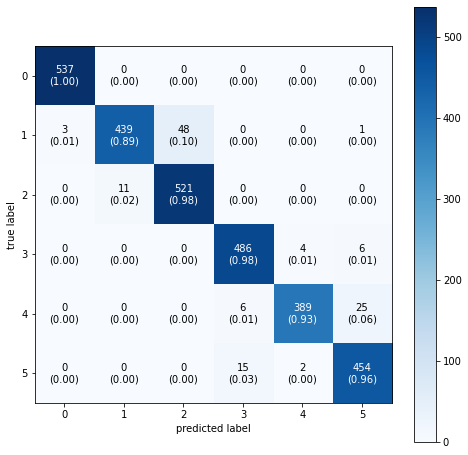

In [85]:
cm = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=cm,
                      show_absolute=True,
                      show_normed=True,
                      colorbar=True,
                      figsize=(8,8))
plt.show()

In [79]:
# Print classificatin report.
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       537
           1       0.98      0.89      0.93       491
           2       0.92      0.98      0.95       532
           3       0.96      0.98      0.97       496
           4       0.98      0.93      0.95       420
           5       0.93      0.96      0.95       471

    accuracy                           0.96      2947
   macro avg       0.96      0.96      0.96      2947
weighted avg       0.96      0.96      0.96      2947



In [76]:
print("Training set score for SVM: %f" % final_model.score(X_train_scaled , y_train))
print("Testing  set score for SVM: %f" % final_model.score(X_test_scaled  , y_test))

Training set score for SVM: 1.000000
Testing  set score for SVM: 0.958941
